# AIPL状态转移矩阵

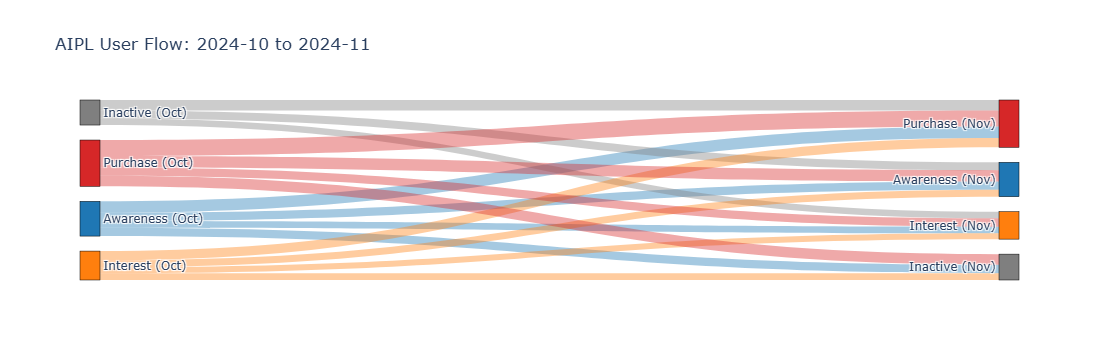

In [9]:
# 定义节点 (左边4个状态 + 右边4个状态)
states = ['Purchase', 'Interest', 'Awareness', 'Inactive']
node_labels = [f"{s} (Oct)" for s in states] + [f"{s} (Nov)" for s in states]

# 颜色配置 (红、橙、蓝、灰)
state_colors = {
    'Purchase': '#d62728', 'Interest': '#ff7f0e', 
    'Awareness': '#1f77b4', 'Inactive': '#7f7f7f'
}
node_colors = [state_colors[s] for s in states] * 2

# === 新增：定义一个函数，正确将 Hex 转为 RGBA ===
def hex_to_rgba(hex_code, alpha):
    hex_code = hex_code.lstrip('#') # 去掉 # 号
    # 将 16 进制字符串切分为 R, G, B 并转为 10 进制整数
    r = int(hex_code[0:2], 16)
    g = int(hex_code[2:4], 16)
    b = int(hex_code[4:6], 16)
    return f"rgba({r}, {g}, {b}, {alpha})"

# 映射 Source/Target 索引
state_to_idx = {s: i for i, s in enumerate(states)} # 0-3
source_indices = []
target_indices = []
values = []
link_colors = []

for _, row in df_counts.iterrows():
    s, t, val = row['source'], row['target'], row['count']
    source_indices.append(state_to_idx[s])      # M1 (0-3)
    target_indices.append(state_to_idx[t] + 4)  # M2 (4-7)
    values.append(val)
    
    # === 修正点：调用函数进行转换 ===
    base_color = state_colors[s]
    # 设置透明度为 0.4
    rgba_color = hex_to_rgba(base_color, 0.4) 
    link_colors.append(rgba_color)

# 绘制图表
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = node_labels,
        color = node_colors
    ),
    link = dict(
        source = source_indices,
        target = target_indices,
        value = values,
        color = link_colors # 现在这里是正确的 rgba 格式了
    ))])

fig.update_layout(title_text=f"AIPL User Flow: {m1_str} to {m2_str}", font_size=12)
fig.c'l()

# 基于RFM优化模型的K-means算法

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from math import pi

# 1. Load Data
df_orders = pd.read_csv('cleaned_orders.csv')
df_logs = pd.read_csv('cleaned_behavior_logs.csv')

# 2. Feature Engineering

# --- Transactional Features (RFM + Discount) ---
# Ensure date format
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])
snapshot_date = df_orders['order_date'].max() + pd.Timedelta(days=1)

# Group by Customer
txn_features = df_orders.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days, # Recency
    'order_id': 'nunique', # Frequency
    'amount': 'sum',       # Monetary
    'discount_applied': 'mean' # Discount Sensitivity
}).reset_index()

txn_features.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary', 'Avg_Discount']

# --- Behavioral Features (Engagement) ---
# Filter out 'purchase' to capture pre-purchase behavior
behavior_logs = df_logs[df_logs['behavior_type'] != 'purchase']
engagement = behavior_logs.groupby('customer_id').size().reset_index(name='Engagement_Score')

# 3. Merge Features
df_features = pd.merge(txn_features, engagement, on='customer_id', how='left')
df_features['Engagement_Score'] = df_features['Engagement_Score'].fillna(0)

# 4. Preprocessing
feature_cols = ['Recency', 'Frequency', 'Monetary', 'Avg_Discount', 'Engagement_Score']
X = df_features[feature_cols].copy()

# Log transform for skewed distributions (Monetary, Frequency, Recency usually log-normal)
# Adding 1 to avoid log(0)
X['Monetary'] = np.log1p(X['Monetary'])
X['Frequency'] = np.log1p(X['Frequency'])
X['Recency'] = np.log1p(X['Recency'])
X['Engagement_Score'] = np.log1p(X['Engagement_Score'])

# Scale Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. K-Means Clustering
# Let's choose K=4 for distinct, actionable groups
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_features['Cluster'] = kmeans.fit_predict(X_scaled)

# 6. Cluster Profiling
# Calculate mean of ORIGINAL features (not scaled/logged) for interpretation
cluster_summary = df_features.groupby('Cluster')[feature_cols].mean().reset_index()
cluster_counts = df_features['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
cluster_summary = pd.merge(cluster_summary, cluster_counts, on='Cluster')

print("Cluster Summary:")
print(cluster_summary)

# 7. Visualization - Radar Chart
def plot_radar_clusters(summary_df, features):
    # Normalize data for the radar chart (Min-Max scaling for visualization only)
    plot_data = summary_df[features].copy()
    for col in features:
        plot_data[col] = (plot_data[col] - plot_data[col].min()) / (plot_data[col].max() - plot_data[col].min())
    
    # Add Cluster label
    plot_data['Cluster'] = summary_df['Cluster']
    
    # Setup Radar
    categories = features
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3'] # Red, Blue, Green, Purple
    labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
    
    for i, row in plot_data.iterrows():
        values = row[categories].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {int(row['Cluster'])}", color=colors[i])
        ax.fill(angles, values, color=colors[i], alpha=0.1)
    
    plt.xticks(angles[:-1], categories, size=12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.title('Deep User Segmentation Profile (Normalized)', size=16, y=1.05)
    plt.tight_layout()
    plt.savefig('cluster_radar.png', dpi=150)
    plt.close()

plot_radar_clusters(cluster_summary, feature_cols)

# 8. Visualization - Scatter Plot (Monetary vs Discount)
plt.figure(figsize=(10, 6))
# Create a scatter plot
# We use original values but maybe log scale for axes to see better
scatter = plt.scatter(df_features['Avg_Discount'], df_features['Monetary'], 
                      c=df_features['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Average Discount Rate')
plt.ylabel('Total Monetary Value')
plt.title('User Segments: Value vs. Price Sensitivity')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.savefig('cluster_scatter.png', dpi=150)

plt.close()
print("Images 'cluster_radar.png' and 'cluster_scatter.png' generated.")

Cluster Summary:
   Cluster     Recency  Frequency      Monetary  Avg_Discount  \
0        0   18.935666  11.713318  10877.491966      0.149806   
1        1  100.640635   8.512244   6649.962662      0.179139   
2        2  105.602572   9.139684   7518.643976      0.126020   
3        3  320.623853   1.142202   1185.305184      0.145092   

   Engagement_Score  Count  
0         17.649549   1772  
1         17.530113   1511  
2         17.622443   1711  
3          1.183486    218  
Images 'cluster_radar.png' and 'cluster_scatter.png' generated.


# 探究K-means模型的聚合点数量选择

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Load Data
df_orders = pd.read_csv('cleaned_orders.csv')
df_logs = pd.read_csv('cleaned_behavior_logs.csv')

# 2. Feature Engineering (Same as before)
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])
snapshot_date = df_orders['order_date'].max() + pd.Timedelta(days=1)

txn_features = df_orders.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'amount': 'sum',
    'discount_applied': 'mean'
}).reset_index()
txn_features.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary', 'Avg_Discount']

behavior_logs = df_logs[df_logs['behavior_type'] != 'purchase']
engagement = behavior_logs.groupby('customer_id').size().reset_index(name='Engagement_Score')

df_features = pd.merge(txn_features, engagement, on='customer_id', how='left')
df_features['Engagement_Score'] = df_features['Engagement_Score'].fillna(0)

feature_cols = ['Recency', 'Frequency', 'Monetary', 'Avg_Discount', 'Engagement_Score']
X = df_features[feature_cols].copy()

# Log Transform
for col in feature_cols:
    X[col] = np.log1p(X[col])

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Model Evaluation Loop (K=2 to K=8)
sse = []
silhouette_scores = []
k_range = range(2, 9)

# To save time, we can sample if dataset is huge, but 5000 users is fine.
sample_X = X_scaled if len(X_scaled) < 10000 else X_scaled[:10000]

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(sample_X)
    sse.append(kmeans.inertia_)
    score = silhouette_score(sample_X, kmeans.labels_)
    silhouette_scores.append(score)

# 4. Visualization - Elbow & Silhouette
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia (SSE)', color=color)
ax1.plot(k_range, sse, marker='o', color=color, label='Inertia (Elbow Method)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_scores, marker='s', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('K-Means Evaluation: Elbow Method & Silhouette Score')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True, alpha=0.3)
plt.savefig('kmeans_evaluation.png', dpi=150)
plt.close()

print(f"Silhouette Score for K=4: {silhouette_scores[k_range.index(4)]:.4f}")
print("SSE Values:", sse)
print("Silhouette Values:", silhouette_scores)

Silhouette Score for K=4: 0.2137
SSE Values: [16680.486793333224, 13257.211194730946, 11510.648605597762, 10229.298117745806, 9180.542185977685, 8584.013769608186, 8078.886810365705]
Silhouette Values: [0.6930965224476424, 0.22907223406770783, 0.21366788082246516, 0.20574573068261287, 0.2057957227450004, 0.1957422555405272, 0.18530410559475335]
